# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from workspace_utils import active_session

from PIL import Image
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Dataset For Training, Validation annd Testing
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [21]:
# Image Transformaiton for Training sets (with Data Augmentation)
train_transforms = transforms.Compose([transforms.RandomResizedCrop((224), scale=(0.6, 1.0), ratio=(1, 1)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Image transformaiton for validation and testing sets (without Data Augmentation)
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(train_dir, transform=test_transforms)
test_data = datasets.ImageFolder(train_dir, transform=test_transforms)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle=True)

# Get No. of Class and Class Idx in Dataset
class_size = len(train_data.classes)
class_to_idx = train_data.class_to_idx

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
cat_to_name

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [22]:
# load model
model_name = 'resnet'

if model_name == 'vgg':
    model = models.vgg16(pretrained = True)
if model_name == 'densenet':
    model = models.densenet121(pretrained = True)
if model_name == 'resnet':
    model = models.resnet101(pretrained = True)


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:05<00:00, 31085746.38it/s]


In [23]:
# Parameters
flag_fc = 0
hidden_units = [1024, 256]
drop_p = 0.5

# Freezing Pre-trained Feature Detectors
for param in model.parameters():
    param.requires_grad = False

# Exception case for ResNet: Check if classifier module exist in model (resnet use 'fc' instead of 'classifier')
if 'classifier.weight' in model.state_dict() or 'classifier.0.weight' in model.state_dict():
    module = next(model.classifier.children(), model.classifier)
else:
    module = next(model.fc.children(), model.fc)
    flag_fc = 1

# Infer input and output sizes from model features
input_size = module.in_features
output_size = class_size
hidden_layers = hidden_units.copy()

# Forming a list of Hidden Layers
hidden_layers.append(output_size)
layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])

# Defining the untrained, feed-forward network, using ReLU activations and dropout
classifier = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
for h1, h2 in layer_sizes:
    classifier.extend([nn.ReLU()])
    classifier.extend([nn.Dropout(p=drop_p)])
    classifier.extend([nn.Linear(h1, h2)])

# Log Softmax as output layer
classifier.extend([nn.LogSoftmax(dim=1)])

# Exception case for ResNet: to use layer name  'fc' instead of 'classifier'
if flag_fc:
    model.fc = nn.Sequential(*classifier)
    optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)
    print(f'''
    Classifying Layers Summary: 
    {model.fc}
    ''')
else:
    model.classifier = nn.Sequential(*classifier)
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
    print(f'''
    Classifying Layers Summary: 
    {model.classifier}
    ''')

# Setting Training Criterion
criterion = nn.NLLLoss()

model_spec = {'Model': model_name,
              'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_units,
              'drop_p' : drop_p,
              'class_to_idx' : class_to_idx,
              'optimizer' : optimizer,
              'criterion' : criterion}


    Classifying Layers Summary: 
    Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=1024, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5)
  (6): Linear(in_features=256, out_features=102, bias=True)
  (7): LogSoftmax()
)
    


In [24]:
def validation(model, validloader):
    # Parameters
    n_test_batch = 5 # reduce n to get faster speed
    
    # Counter reset
    running_loss = 0
    accuracy = 0
    
    # ensure model running on desired device
    model.to(device)
    
    for i in range(n_test_batch):
        images, labels = next(iter(validloader))
        # ensure tensor running on GPU
        images, labels = images.to(device), labels.to(device)
        
        # calculate loss
        outputs = model.forward(images)
        vloss = criterion(outputs, labels)
        vloss = vloss.item() 
        
        running_loss += vloss
        
        # return probability (0-1)
        ps = torch.exp(outputs)
        
        # calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    # return test loss and accuracy across all images in validation image set
    test_loss = running_loss/n_test_batch
    accuracy = accuracy/n_test_batch
    
    return test_loss, accuracy

In [25]:
def train_network(model, epochs):
    # parameters
    criterion, optimizer = model_spec['criterion'], model_spec['optimizer']
    epochs = epochs
    eval_every = 10
        
    with active_session():
        # counter reset
        steps = 0 # counter for total no. of batches
        list_tloss, list_vloss, list_step = [], [], []
            
        model.to(device)
            
        print('Training has started.')
            
        for e in range(epochs):
            # counter reset
            running_loss = 0
            estep = 0 # counter for no. of batches per epoch
                
            model.train() # Train mode on

            for images, labels in trainloader:               
                # Ensure parameters are reset at start
                images, labels = images.to(device), labels.to(device)
                steps += 1
                estep  += 1
                optimizer.zero_grad()

                # Feedforward & Backpropagation
                outputs = model.forward(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Calculation of Loss averaged across every (print_every) iterations
                running_loss += loss.item()
                    
                # Evaluation part, with results printed on screen
                if estep % eval_every == 0:
 
                    model.eval() 

                    # Evaluation with Validation Set
                    with torch.no_grad():
                        valid_loss, accuracy = validation(model, validloader)
                            
                    print(f"Epoch: {e+1}/{epochs}", 
                          f"Training Loss: {running_loss/eval_every :.3f}",
                          f"Valid Loss: {valid_loss :.3f}", 
                          f"Valid Accuracy: {accuracy*100 :.2f}%")

                    # Recoding each evaluation results
                    list_tloss.append(running_loss/eval_every)
                    list_vloss.append(valid_loss)
                    list_step.append(steps)

                    model.train()
                    running_loss = 0

    print('Training completed!')
    
    # Saving a Check Point
    checkpoint = {'model_spec': model_spec,
                  'state_dict': model.state_dict(),
                  'training loss': list_tloss,
                  'valid loss': list_vloss,
                  'steps': list_step,
                  'optimizer_stat_dict' : optimizer.state_dict()}
    
    train_stat_dict = {
    'training loss': checkpoint['training loss'],
    'validation loss': checkpoint['valid loss'],
    'steps': checkpoint['steps']}
        
    checkpoint_dir = 'checkpoint_' + model_name + '.pth'
    torch.save(checkpoint, checkpoint_dir)
    print(f'''
    Checkpoint saved.
    Checkpoint Directory: {checkpoint_dir}
    ''')
    
    return train_stat_dict

In [26]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
train_stat_dict = train_network(model, 10)

Training has started.
Epoch: 1/10 Training Loss: 4.701 Valid Loss: 4.546 Valid Accuracy: 3.12%
Epoch: 1/10 Training Loss: 4.580 Valid Loss: 4.470 Valid Accuracy: 7.50%
Epoch: 1/10 Training Loss: 4.518 Valid Loss: 4.376 Valid Accuracy: 9.38%
Epoch: 1/10 Training Loss: 4.458 Valid Loss: 4.316 Valid Accuracy: 9.38%
Epoch: 1/10 Training Loss: 4.388 Valid Loss: 4.282 Valid Accuracy: 10.00%
Epoch: 1/10 Training Loss: 4.287 Valid Loss: 4.153 Valid Accuracy: 11.25%
Epoch: 1/10 Training Loss: 4.206 Valid Loss: 4.076 Valid Accuracy: 13.75%
Epoch: 1/10 Training Loss: 4.020 Valid Loss: 3.836 Valid Accuracy: 17.50%
Epoch: 1/10 Training Loss: 3.989 Valid Loss: 3.550 Valid Accuracy: 21.88%
Epoch: 1/10 Training Loss: 3.712 Valid Loss: 3.416 Valid Accuracy: 23.12%
Epoch: 2/10 Training Loss: 3.520 Valid Loss: 3.003 Valid Accuracy: 31.88%
Epoch: 2/10 Training Loss: 3.231 Valid Loss: 2.790 Valid Accuracy: 39.38%
Epoch: 2/10 Training Loss: 3.060 Valid Loss: 2.674 Valid Accuracy: 36.25%
Epoch: 2/10 Training

In [18]:
def plot_train_stat(checkpoint):
    df = pd.DataFrame(checkpoint)
    plt.plot('steps','training loss', data = df)
    plt.plot('steps','validation loss', data = df)
    plt.xlabel('Steps');
    plt.ylabel('Loss');
    plt.title(model_name)
    plt.legend();

## Training Stat: VGG16

Accuracy on Test Set: 85.00%


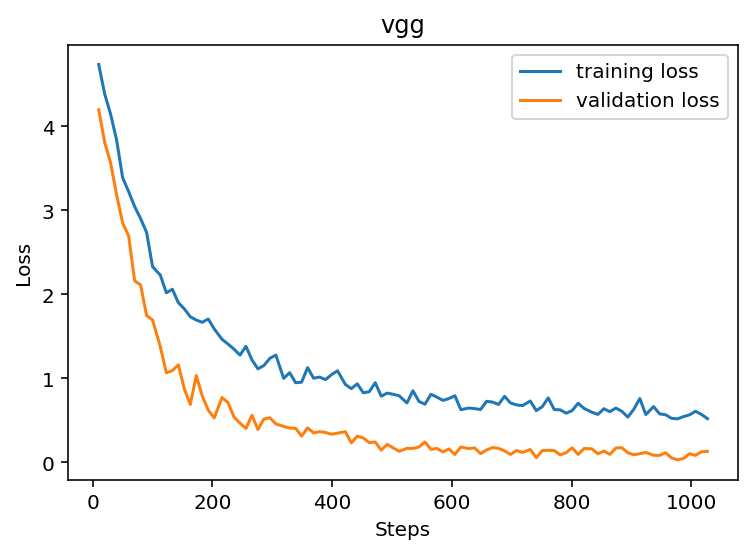

In [89]:
# plot_train_stat(checkpoint)
plot_train_stat(train_stat_dict)

with torch.no_grad():
    test_loss, accuracy = validation(model, testloader)

print(f"Accuracy on Test Set: {accuracy * 100 :.2f}%")

## Training Stat: ResNet-101

Accuracy on Test Set: 81.88%


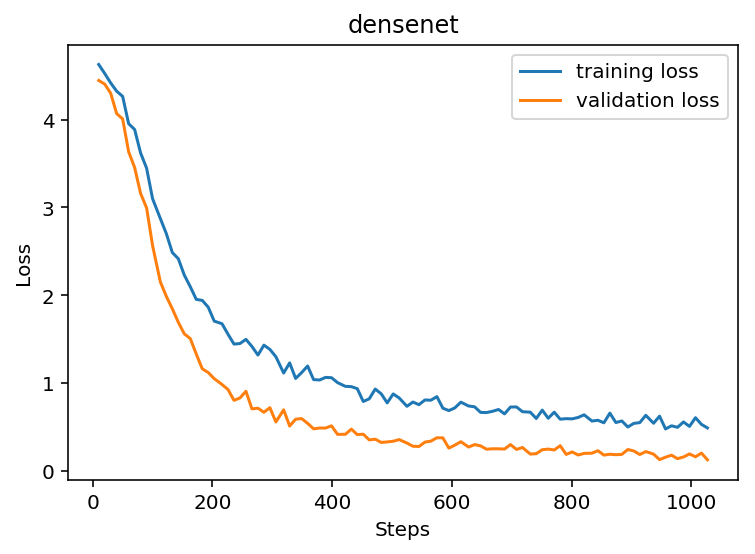

In [20]:
plot_train_stat(train_stat_dict)

with torch.no_grad():
    test_loss, accuracy = validation(model, testloader)

print(f"Accuracy on Test Set: {accuracy * 100 :.2f}%")

## Training Stat: DenseNet-121

Accuracy on Test Set: 76.88%


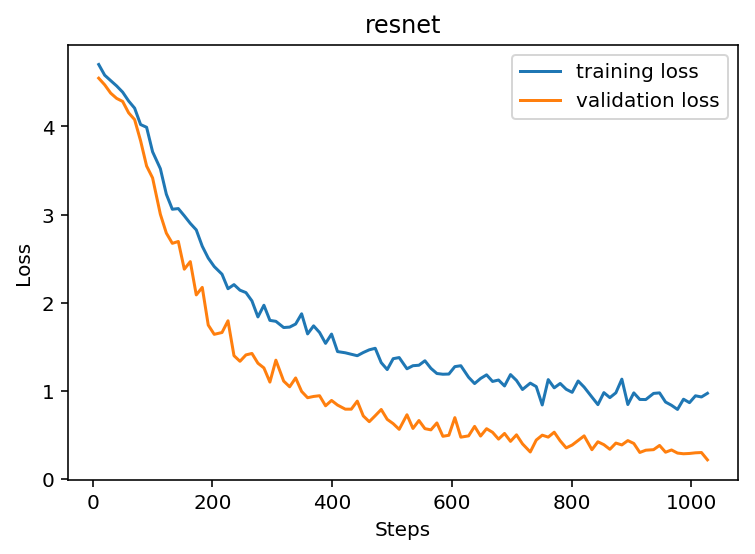

In [27]:
plot_train_stat(train_stat_dict)
with torch.no_grad():
    test_loss, accuracy = validation(model, testloader)

print(f"Accuracy on Test Set: {accuracy * 100 :.2f}%")

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [19]:
# TODO: Do validation on the test set
with torch.no_grad():
    test_loss, accuracy = validation(model, testloader, criterion)

print(f"Accuracy on Test Set: {accuracy * 100 :.2f}%")

Accuracy on Test Set: 82.50%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [162]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath, retrain = False):
    checkpoint = torch.load(filepath)
    model_spec = checkpoint['model_spec']
    optimizer = model_spec['optimizer']
    
    model_name = model_spec['Model']

    if model_name == 'vgg':
        model = models.vgg16(pretrained = True)
    if model_name == 'densenet':
        model = models.densenet121(pretrained = True)
    if model_name == 'resnet':
        model = models.resnet101(pretrained = True)

    
    # Rebilding the Model
    for param in model.parameters():
        param.requires_grad = False
    
    # Use model specification info if available
    input_size = model_spec['input_size']
    output_size = model_spec['output_size']
    hidden_layers = model_spec['hidden_layers']
    
    # Forming a list of Hidden Layers
    hidden_layers.append(output_size)
    layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
    
    # Defining the untrained, feed-forward network, using ReLU activations and dropout
    classifier = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
    for h1, h2 in layer_sizes:
        classifier.extend([nn.ReLU()])
        classifier.extend([nn.Dropout(p=drop_p)])
        classifier.extend([nn.Linear(h1, h2)])
        
    # Log Softmax as output layer
    classifier.extend([nn.LogSoftmax(dim=1)])
    
    if model_name == 'resnet':
        model.fc = nn.Sequential(*classifier)
        optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)
    
    else: 
        model.classifier = nn.Sequential(*classifier)
        optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

    criterion = nn.NLLLoss()
    
    # Load Trained Weight and Bias
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_stat_dict'])

    return model, model_spec


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

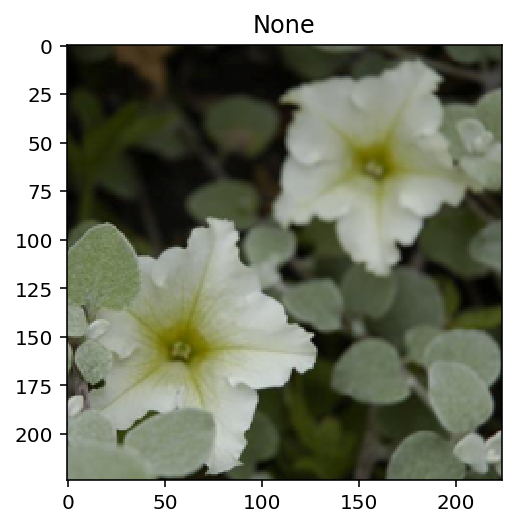

In [155]:
# TODO: Process a PIL image for use in a PyTorch model
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Obtain image size info
    w,h = image.size
    aspect_ratio = w/h

    # Resizing Image to have shortest eide = 256
    if aspect_ratio < 1:
        new_w = 256
        new_h = int(round(256/aspect_ratio,0))
    elif aspect_ratio > 1:
        new_w = int(round(256*aspect_ratio,0))
        new_h = 256
    else:
        new_w, new_h = 256,256

    image.thumbnail((new_w,new_h))
    
    # Center-cropping Image to size (224,224)
    area = ((new_w-224)/2, (new_h-224)/2, (new_w-224)/2+224, (new_h-224)/2+224)
    cropped_image = image.crop(area)
    
    # Convert to Numpy array
    np_image = np.array(cropped_image)

    # Normalize image and Transpose to (RGB, w, h) format to fit PyTorch Pre-trained Models
    norm_mean = np.array([0.485, 0.456, 0.406])
    norm_std =  np.array([0.229, 0.224, 0.225])
    np_image_norm = ((np_image/255)-norm_mean)/norm_std
    np_image_norm_t = np_image_norm.transpose(2,0,1)

    return np_image_norm_t

# Func Test

# add a func, img randomizer here

img_path, img_true_class = rand_img_loader(df_file)
image = Image.open(img_path)
np_image = process_image(image);
imshow(np_image);

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [156]:
# TODO: Implement the code to predict the class from an image file
    
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    np_image = process_image(image_path)
    
    # further processing to fit the trained model
    img = torch.from_numpy(np_image)
    img = img.type(torch.FloatTensor)
    img.resize_(1,3,224,224)
    
    # prediction
    with torch.no_grad():
        img, model = img.to(device), model.to(device)

        outputs = model.forward(img)
        
        # obtain top 5 predicted class
        probs, classes = torch.topk(torch.exp(outputs),5,dim=1)
        pred = torch.max(torch.exp(outputs),dim=1)[1]
        
        # return list items
        probs, classes, pred = probs.to('cpu'), classes.to('cpu'), pred.to('cpu')
        probs, classes, pred = probs.numpy()[0],classes.numpy()[0], pred.numpy()[0]
        
        top5_predict = pd.DataFrame({'classes': classes, 'probabilities': probs})
    
    return top5_predict, pred

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [31]:
def parse_idx_to_label(df): 
    df['classes'] = df['classes'].map(idx_to_class)
    df['classes'] = df['classes'].map(cat_to_name)
    return df

In [90]:
# Create file list for random image loader
import os
test_img_path = "flowers/test"
file_list = []
class_codes = os.listdir('flowers/test')
for class_code in class_codes:
    image_names = os.listdir(f'{test_img_path}/{class_code}')
    for image_name in image_names:
        file_list.append(f'{test_img_path}/{class_code}/{image_name}')
        file_list.append(class_code)
file_dict = {'filedir' : file_list[::2], 
             'class' : file_list[1::2]}
df_file = pd.DataFrame(file_dict)
df_file['class'] = df_file['class'].map(cat_to_name)

def rand_img_loader(df_file):
    load_idx = np.random.randint(0,len(df_file))
    img_dir = df_file['filedir'].iloc[load_idx]
    img_class = df_file['class'].iloc[load_idx]
    return img_dir, img_class

('flowers/test/4/image_05653.jpg', 'sweet pea')

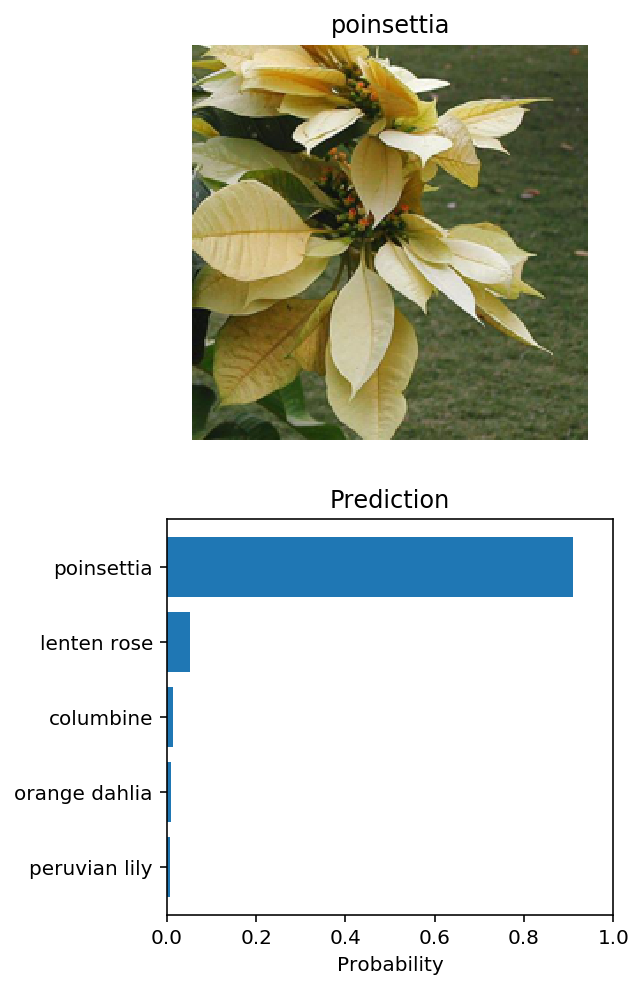

In [166]:
# TODO: Display an image along with the top 5 classes

# Load image and model
img_path, img_true_class = rand_img_loader(df_file)
image_path = Image.open(img_path)
model, model_spec = load_checkpoint('checkpoint_vgg.pth');

# model = load_checkpoint('checkpoint_resnet.pth')
# model = load_checkpoint('checkpoint_densenet.pth')

# Obtain prediction from pre-trained model
df_pred, pred = predict(image_path, model);

# Parse predicted indices back to Labels
class_to_idx = model_spec['class_to_idx']
idx_to_class = dict([ (v, k) for k, v in class_to_idx.items( ) ])

df = parse_idx_to_label(df_pred)
class_predicted = cat_to_name[idx_to_class[pred]]


# Display Results
fig, (ax1,ax2) = plt.subplots(2, figsize=(4,8))

# Subplot1: Display Image with image true class as title
imshow(process_image(image_path),ax1,title=img_true_class) #if using the test photo randomizer
# imshow(process_image(image_path),ax1,title=class_predicted) #if using the other photos
ax1.axis('off')

# Subplot 2: Display top 5 predicted class and probebilities
# Redordering the labels to be plotted from top1 to 5
df = df.sort_values('probabilities', ascending = False)
order_list = df.classes.values
order_list

ax2.barh(range(len(order_list),0,-1),df.probabilities, tick_label = order_list);
ax2.set_title('Prediction')
plt.xlabel('Probability');
plt.xlim([0,1]);
